# Data Augmentation

More data typically increases model performance. So, what do we do if we have small amounts of image training data and cannot collect more? One popular method is data augmentation.

**Data augmentation** is the increase of an existing training dataset's size and diversity without the requirement of manually collecting any new data. The approach generates additional training data from existing examples by augmenting them using random transformations that yield believable-looking images, which exposes the model to more aspects of the data and helps it generalize better.

We train a deep learning model to tune its parameters so it can effectively map a particular input (e.g., an image) to some output (e.g., a label). The goal is to find the sweet spot where the model’s loss is low, which happens when your parameters are tuned in the right way.

Specifically, data augmentation is acquired by performing a series of random preprocessing transformations to existing data such as horizontal and vertical flipping, skewing, cropping, shearing, zooming in and out, and rotating. Collectively, augmented data is able to simulate a variety of subtly different data points as opposed to just duplicating the same data. The subtle differences of the augmented images should (hopefully) be enough to help train a more robust model.

Data augmentation can also mitigate overfitting. Overfitting generally occurs when there are a small number of training examples. By generating additional training data from existing examples, we may mitigate overfitting.

General resource:

https://www.charterglobal.com/image-data-augmentation-and-ai/

# Import **tensorflow** Library

In [1]:
import tensorflow as tf

# GPU Hardware Accelerator

To vastly speed up processing, we can use the GPU available from the Google Colab cloud service. Colab provides a free Tesla K80 GPU of about 12 GB. It’s very easy to enable the GPU in a Colab notebook:

1.	click **Runtime** in the top left menu
2.	click **Change runtime** type from the drop-down menu
3.	choose **GPU** from the Hardware accelerator drop-down menu
4.	click **SAVE**

Verify that GPU is active:

In [2]:
tf.__version__, tf.test.gpu_device_name()

('2.4.1', '/device:GPU:0')

If '/device:GPU:0' is displayed, the GPU is active. If '..' is displayed, the regular CPU is active.

# Work with Flowers Data

Import libraries:

In [3]:
import numpy as np
import PIL.Image

Download data with **tf.keras.utils.get_file** utility:

In [4]:
import pathlib

url1 = 'https://storage.googleapis.com/download.tensorflow.org/'
url2 = 'example_images/flower_photos.tgz'
dataset_url = url1 + url2

data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

## Split Data

Load images off disk using **tf.keras.preprocessing.image_dataset_from_directory** utility into train and test sets.

Set parameters:

In [5]:
BATCH_SIZE = 32
img_height = 180
img_width = 180

Batch size is set to 32. Since images have different shapes, images are resized to 180 x 180 for model consumption.

### Create Train and Test Sets

The **tf.keras.preprocessing.image_dataset_from_directory** utiltity reads the data from a directory. It then splits, seeds, resizes, and batches the data.

Create the train set:

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.19,
  subset='training',
  seed=0,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2973 files for training.


Set **validation_split=0.19** and **subset='training'**, to get 81% train data.

Create the test set:

In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.19,
  subset='validation',
  seed=0,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 697 files for validation.


Set **validation_split=0.19** and **subset='validation'**, to get 19% test data.

## Inspect Train Set

Take an example batch and display image shape and label:

In [8]:
for images, labels in train_ds.take(1):
  print ('image shape:', images.shape)
  print ('labels:', labels.numpy())
  print ('number of labels in a batch:', len(labels))

image shape: (32, 180, 180, 3)
labels: [2 0 0 4 1 3 1 2 0 0 1 4 0 1 4 2 4 0 0 4 0 1 2 1 2 1 2 0 1 2 1 0]
number of labels in a batch: 32


As expected, we have 32 180 x 180 images in the first batch. We also have 32 corresponding labels.

## Get Number of Classes

Display number of labels:

In [9]:
class_names = train_ds.class_names
num = len(class_names)
num

5

## Create Scale Function

Create a function to scale images:

In [10]:
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.0
  return image, label

## Build the Input Pipeline

Scale train and test sets. Shuffle train data, cache, ahd prefetch train and test data.

In [11]:
SHUFFLE_SIZE = 100

train_fds = train_ds.map(scale).shuffle(SHUFFLE_SIZE).\
            cache().prefetch(1)
test_fds = test_ds.map(scale).cache().prefetch(1)

<!-- Use AUTOTUNE: -->

# Apply Data Augmentation with Preprocessing Layers

Apply data augmentation with experimental Keras Preprocessing Layers. We include the layers inside a model like other layers. Let's augment images by randomly flipping horizonatally, rotating, zooming, and translating.

In [12]:
from tensorflow.keras.layers.experimental.preprocessing\
  import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing\
  import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing\
  import RandomZoom
from tensorflow.keras.layers.experimental.preprocessing\
  import RandomTranslation


data_augmentation = tf.keras.Sequential(
  [
   RandomFlip('horizontal'),
   RandomRotation(0.1),
   RandomZoom(0.1),
   RandomTranslation(height_factor=0.2, width_factor=0.2)
  ]
)

Resources:

https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

https://www.tensorflow.org/tutorials/images/data_augmentation

## Display an Augmented Image

Here is what happens when applying data augmentation to the same image several times:

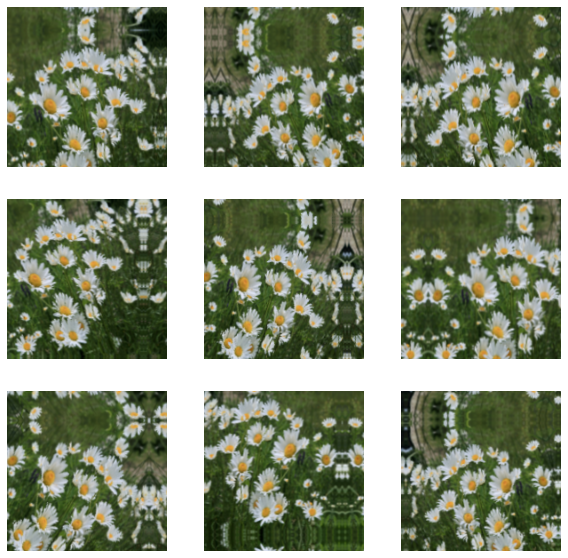

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, _ in train_fds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0])
    plt.axis('off')

## Clear Models and Generate Seed

Clear all previous models and generate a seed for reproducibility:

In [14]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

## Import Libraries

Import requisite libraries to build the model:

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D

## Build Model

Build a multi-layered CNN:

In [16]:
model = tf.keras.Sequential([
  data_augmentation,
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(num)
])

## Compile

Compile with SparseCategoricalCrossentropy(from_logits=True):

In [17]:
model.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## Train

Train model for three epochs:

In [18]:
history = model.fit(
    train_fds,
    validation_data=test_fds,
    epochs=10)

Epoch 1/10
93/93 [==============================] - 12s 40ms/step - loss: 1.5477 - accuracy: 0.2866 - val_loss: 1.1315 - val_accuracy: 0.5366
Epoch 2/10
93/93 [==============================] - 2s 19ms/step - loss: 1.2181 - accuracy: 0.4668 - val_loss: 1.0315 - val_accuracy: 0.5925
Epoch 3/10
93/93 [==============================] - 2s 19ms/step - loss: 1.1174 - accuracy: 0.5395 - val_loss: 1.0109 - val_accuracy: 0.5997
Epoch 4/10
93/93 [==============================] - 2s 19ms/step - loss: 1.0382 - accuracy: 0.5690 - val_loss: 1.0370 - val_accuracy: 0.6112
Epoch 5/10
93/93 [==============================] - 2s 19ms/step - loss: 0.9998 - accuracy: 0.6067 - val_loss: 1.0320 - val_accuracy: 0.6169
Epoch 6/10
93/93 [==============================] - 2s 19ms/step - loss: 0.9639 - accuracy: 0.6097 - val_loss: 0.9317 - val_accuracy: 0.6585
Epoch 7/10
93/93 [==============================] - 2s 19ms/step - loss: 0.9398 - accuracy: 0.6362 - val_loss: 0.8876 - val_accuracy: 0.6786
Epoch 8/10
9

# Apply Data Augmentation Directly on Images

Instead of creating a training model with an augmentation layer, we can perform transformations directly on images.

General resource:

https://medium.com/mlait/image-data-augmentation-image-processing-in-tensorflow-part-2-b77237256df0

TensorFlow resource:

https://towardsdatascience.com/tensorflow-image-augmentation-on-gpu-bf0eaac4c967

Grab some images from the training set we created earlier in the notebook:

In [19]:
for batch_images, _ in train_fds.take(1):
  print ('image shape:', batch_images.shape)

image shape: (32, 180, 180, 3)


Since a training set of images was already created earlier in the notebook, just grab the first batch. Now, we have a batch of 32 images with which to play.

## Set Index

Since batch size is 32, we can set the value from 0 to 31.

In [20]:
indx = 0
indx

0

We set the index to grab the first image from the batch. Change the index value (between 0 and 31) to display different images.

Image:

In [21]:
our_image = batch_images[indx]

## Show an Example

Display the image:

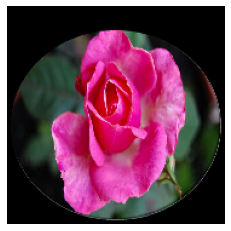

In [22]:
plt.imshow(our_image)
plt.axis('off')
plt.grid(b=None)

## Create Functions to Show Images

Show original and modified image:

In [23]:
def show(original_img, trans_img):
  f = plt.figure(figsize=(6, 6))
  f.add_subplot(1,2,1)
  plt.imshow(original_img)
  plt.axis('off')
  f.add_subplot(1,2,2)
  plt.imshow(trans_img)
  plt.axis('off')
  plt.show(block=True)

Show several transformations of an image:

In [24]:
def show_images(img, indx, trans, p1=None, p2=None, b=False):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    if not b:
      new_img = trans(img[indx])
    elif p2==None:
      new_img = trans(img[indx], p1)
      new_img = np.clip(new_img, 0, 1)
    else:
      new_img = trans(img[indx], p1, p2)
      new_img = np.clip(new_img, 0, 1)
    plt.imshow(new_img)
    plt.axis('off')

## Demonstrate Examples

Let's demonstrate how to augment directly on images.

Resource:

https://www.tensorflow.org/api_docs/python/tf/image/

## Crop an Image

To **crop** an image, remove or adjust its outside edges.

Crop:


In [25]:
new_image = tf.image.random_crop(our_image, [120, 120, 3])
new_image.shape

TensorShape([120, 120, 3])

Show original and modified image:

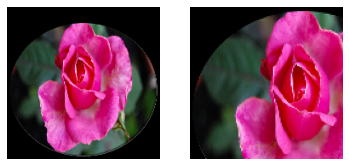

In [26]:
show(our_image, new_image)

Since the transformation is random, the image is cropped randomly:

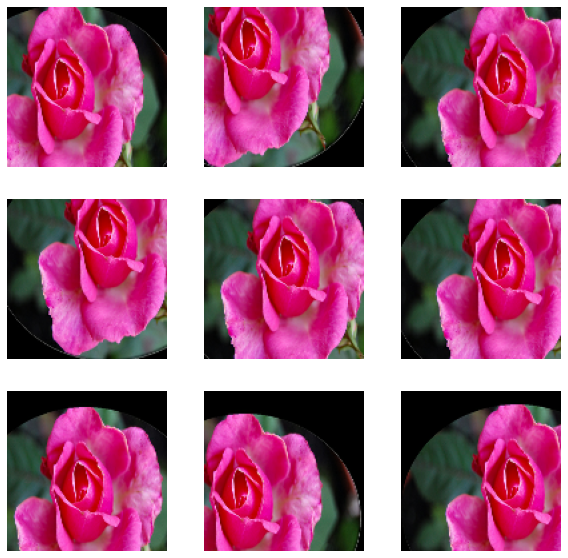

In [27]:
show_images(batch_images, indx, tf.image.random_crop,
            [120, 120, 3], b=True)

Centrally crop:

(90, 90, 3)


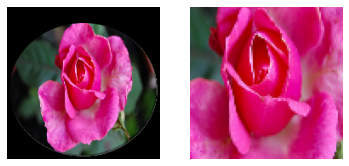

In [28]:
new_image = tf.image.central_crop(our_image, 0.5)
print (new_image.shape)
show(our_image, new_image)

Crop to a bounding box:

(120, 120, 3)


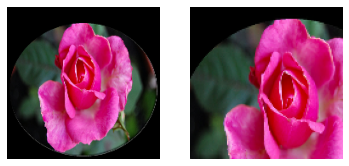

In [29]:
new_image = tf.image.crop_to_bounding_box(
    our_image, 10, 10, 120, 120)
print (new_image.shape)
show(our_image, new_image)


## Randomly Flip Image Left to Right

Since the transformation is random, the image isn't always flipped:

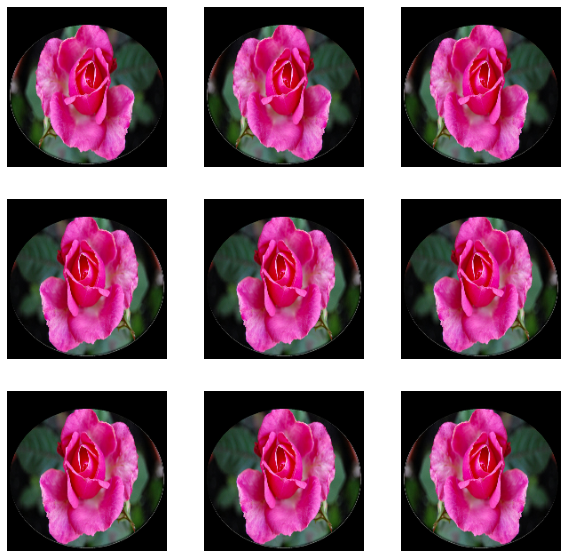

In [30]:
show_images(batch_images, indx, tf.image.random_flip_left_right)

## Randomly Flip Image Up to Down

Since the transformation is random, the image isn't always flipped:

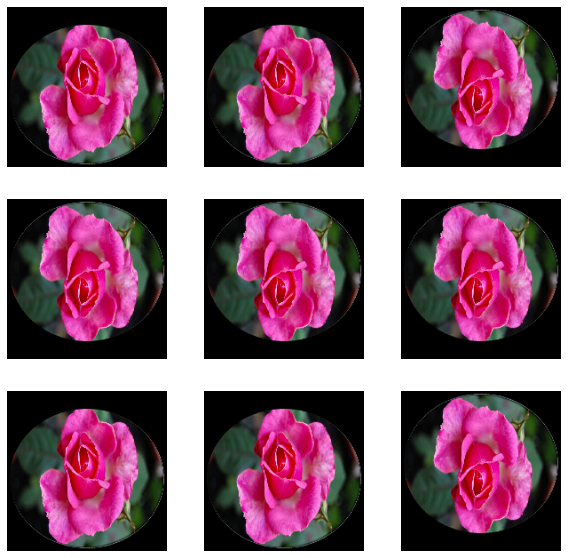

In [31]:
show_images(batch_images, indx, tf.image.random_flip_up_down)

## Flip Image Up to Down

The image is always flipped:

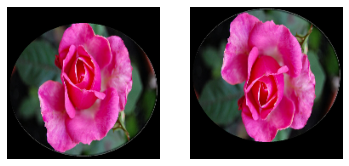

In [32]:
show(our_image, tf.image.flip_up_down(our_image))

## Rotate Image 90 Degrees

Each **k** value rotates the image 90 degrees.

Rotate 90 degrees:

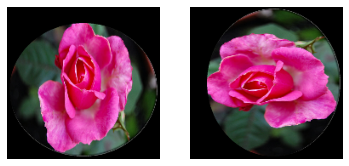

In [33]:
show(our_image, tf.image.rot90(our_image, k=1))

Rotate 180 degrees:

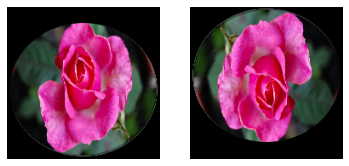

In [34]:
show(our_image, tf.image.rot90(our_image, k=2))

Rotate 270 degrees:

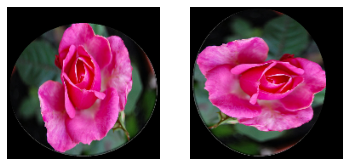

In [35]:
show(our_image, tf.image.rot90(our_image, k=3))

Rotate 360 degrees:

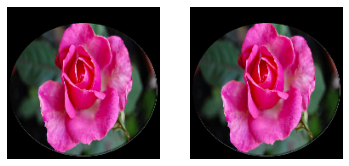

In [36]:
show(our_image, tf.image.rot90(our_image, k=4))

We're back where we started!

## Adjust Gamma

**Gamma encoding** can be thought of as the intensity of an image. It is used to optimize the usage of bits when encoding an image by taking advantage of the non-linear manner that humans perceive light and color. The human perception of brightness (lightness) under common illumination conditions (neither pitch black nor blindingly bright) follows an approximate power function with greater sensitivity to relative differences between darker tones than between lighter tones.

Resource:

https://en.wikipedia.org/wiki/Gamma_correction

Adjust with gamma encoding:

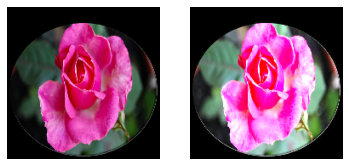

In [37]:
new_image = tf.image.adjust_gamma(
    our_image, gamma=0.75, gain=1.5)
new_image = np.clip(new_image, 0, 1)
show(our_image, new_image)

Adjust gamma for brightness. For gamma less than 1, image is brighter. For gamma greater than 1, image is darker. Intensity is controlled by gain. Apply NumPy clip function to ensure that pixel values are still in between [0, 1].

## Adjust Contrast

**Contrast** in image processing is the difference in luminance (or color) that makes an object distinguishable. It is determined by the difference in the color and brightness of the object and other objects within the same field of view.

Fixed contrast:

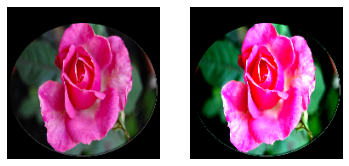

In [38]:
new_image = tf.image.adjust_contrast(
    our_image, contrast_factor=1.8)
new_image = np.clip(new_image, 0, 1)
show(our_image, new_image)

Adjust contrast_factor for more or less luminance.

Random contrast:

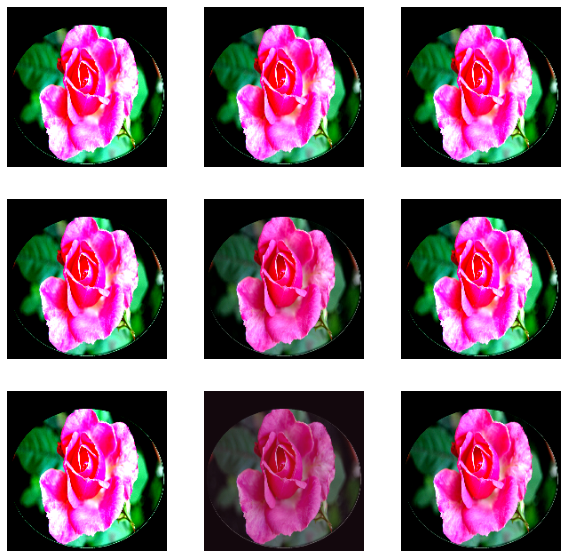

In [39]:
show_images(batch_images, indx, tf.image.random_contrast,
            0.75, 2.9, b=True)

## Adjust Brightness

Fixed brightness:

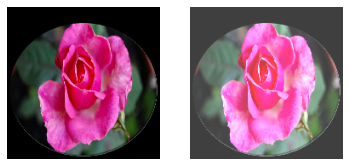

In [40]:
new_image = tf.image.adjust_brightness(our_image, .25)
new_image = np.clip(new_image, 0, 1)
show(our_image, new_image)

Random brightness:

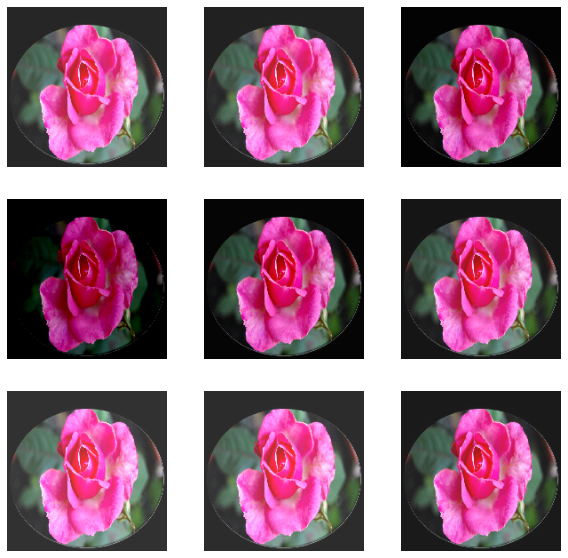

In [41]:
show_images(batch_images, indx, tf.image.random_brightness,
            0.25, b=True)

## Adjust Saturation

**Saturation** in image processing is the depth or intensity of color present within an image. The more saturated an image, the more colorful and vibrant it appears. Less color saturation makes an image appear subdued or muted.

Fixed saturation:

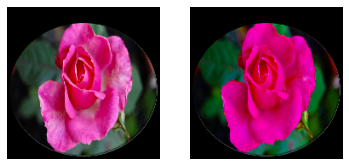

In [42]:
show(our_image, tf.image.adjust_saturation(our_image, 3.0))

Random saturation:

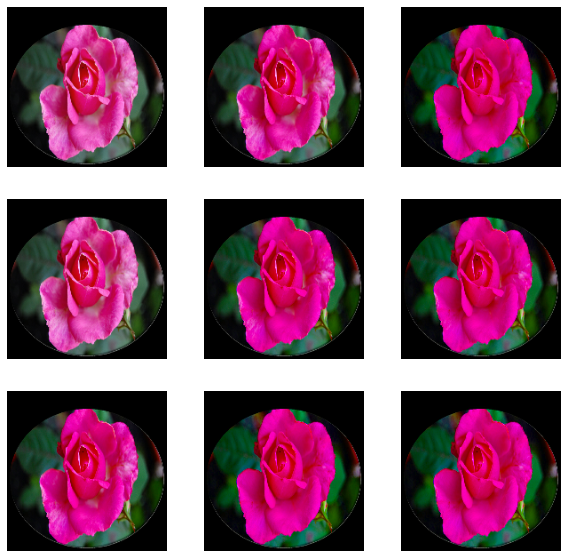

In [43]:
show_images(batch_images, indx, tf.image.random_saturation,
            0.3, 3.5, b=True)

## Adjust Hue

**Hue** is the main indication of a RGB color. It is the value that tells us whether an object is red, green or blue. In contrast, saturation is the perceived intensity. So saturation is how colorful the object looks, while hue is the actual color.

Fixed hue:

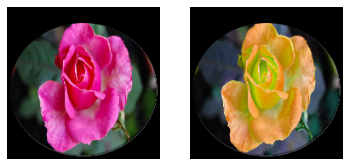

In [44]:
show(our_image, tf.image.adjust_hue(our_image, 0.2))

Random hue:

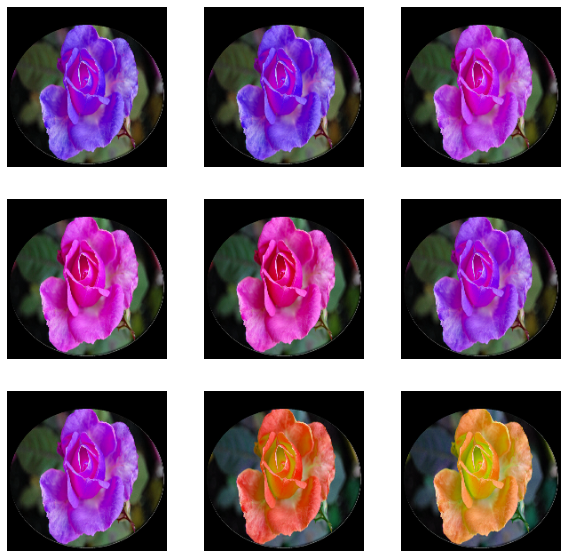

In [45]:
show_images(batch_images, indx, tf.image.random_hue, 0.2, b=True)

## Create an Augmentation Function

Randomly flip images from left to right apply a saturation operation to images:

In [46]:
def augment(image, label):
  img = tf.image.random_flip_left_right(image)
  final_image = tf.image.random_saturation(img, 0, 2)
  return (final_image, label)

## Display an Augmented Image

Here is what happens when the **augment** function is applied to the same image several times:

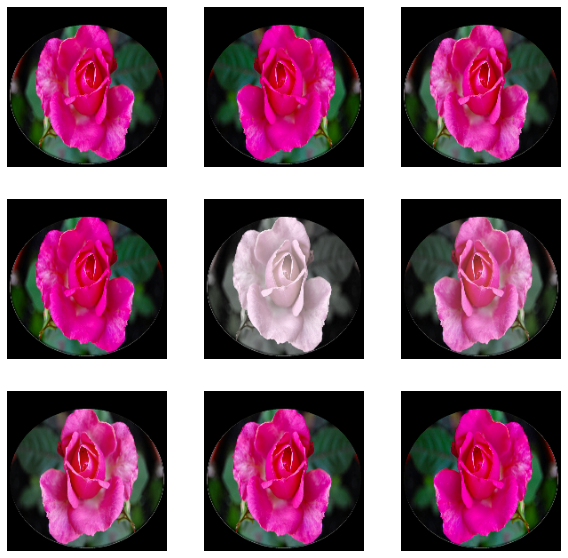

In [47]:
plt.figure(figsize=(10, 10))
for i in range(9):
  image, _ = augment(our_image, labels[0])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.axis('off')

## Build the Input Pipeline

Build a pipeline with train and test data:

In [48]:
SHUFFLE_SIZE = 10000

train1 = train_ds.map(scale, num_parallel_calls=4)
train2 = train1.map(augment, num_parallel_calls=4)
train_da = train2.shuffle(SHUFFLE_SIZE).cache().prefetch(1)
test_da = test_ds.map(scale).cache().prefetch(1)

Use **num_parallel** parameter for better performance.

## Clear Previous Models and Generate Seed

Clear previous models and seed:

In [49]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

## Create Model

Create a multi-layer CNN:

In [50]:
model = tf.keras.Sequential([
  Conv2D(32, 3, activation='relu',
         input_shape=[180, 180, 3]),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(num)
])

## Compile

Compile with SparseCategoricalCrossentropy(from_logits=True):

In [51]:
model.compile(
  optimizer='adam',
  loss=SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

## Train

Train the model:

In [52]:
history = model.fit(
    train_da,
    validation_data=test_da,
    epochs=5)

Epoch 1/5
93/93 [==============================] - 10s 31ms/step - loss: 1.5751 - accuracy: 0.2774 - val_loss: 1.2142 - val_accuracy: 0.4921
Epoch 2/5
93/93 [==============================] - 1s 15ms/step - loss: 1.3038 - accuracy: 0.4497 - val_loss: 1.0983 - val_accuracy: 0.5882
Epoch 3/5
93/93 [==============================] - 1s 15ms/step - loss: 1.1994 - accuracy: 0.5145 - val_loss: 1.0098 - val_accuracy: 0.6112
Epoch 4/5
93/93 [==============================] - 1s 15ms/step - loss: 1.0424 - accuracy: 0.5992 - val_loss: 0.9229 - val_accuracy: 0.6628
Epoch 5/5
93/93 [==============================] - 1s 15ms/step - loss: 0.8891 - accuracy: 0.6709 - val_loss: 0.9150 - val_accuracy: 0.6657


# Data Augmentation with ImageGenerator

So far, we have augmented images in two ways. We utilized Keras preprocessing layers and applied TensorFlow operations directly on images to augment. Both methods build a tf.data pipeline to model the augmented dataset.

An alternative is to use the ImageGenerator class. The ImageGenerator class makes it easy to load images from disk and augment them in various ways.
We can shift, rotate, rescale, flip horizontally or vertically, shear or apply transformation functions to images. Although ImageGenerator is very convenient for simple projects, building a tf.data pipeline is more conducive to complex projects because it can read images in parallel from any source (not just a local disk), manipulate the dataset in any manner, and preprocessing functions based on tf.image operations can be used in the tf.data pipeline and in the model deployed to production.


Resource:

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

## Use ImageDataGenerator to Process Flowers Data

Load data directly from the flowers directory into train and test splits by utilizing dictionaries. The first dictionary provides scaling and splitting information to the ImageDataGenerator class. The second dictionary provides target and batch information to the class.

Import the appropriate library:

In [53]:
from tensorflow.keras.preprocessing.image\
  import ImageDataGenerator

Create a dictionary to scale and split data:

In [54]:
datagen_kwargs = dict(rescale=1./255, validation_split=.19)

Split is 81/19.

Create a dictionary to resize, batch, and interpolate:

In [55]:
BATCH_SIZE = 32
IMAGE_SIZE = (180, 180)

dataflow_kwargs = dict(target_size=IMAGE_SIZE,
                       batch_size=BATCH_SIZE,
                       interpolation='bilinear')

### Create Validation Data

Create the test set:

In [56]:
valid_datagen = tf.keras.preprocessing.image.\
  ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset='validation', shuffle=False,
    **dataflow_kwargs)

Found 694 images belonging to 5 classes.


### Create Train Data

Create the train set:

In [57]:
train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset='training', shuffle=True,
    **dataflow_kwargs)

Found 2976 images belonging to 5 classes.


### Clear Models and Generate Seed

Clear previous models and generate a seed:

In [58]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

### Create Model

Create a multi-layer CNN:

In [59]:
model = Sequential([
  Conv2D(filters=32, kernel_size=(5, 5), activation = 'relu',
         input_shape=(180, 180, 3)),
  MaxPooling2D(2),
  Conv2D(64, (5, 5), activation='relu'),
  MaxPooling2D(2),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(5, activation='softmax')
])

### Compile

Compile with categorical_crossentropy:

In [60]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train

Train for one epoch:

In [61]:
history = model.fit(train_generator, batch_size=BATCH_SIZE,
                    epochs=5, validation_data=valid_generator,
                    verbose=1)

Epoch 1/5
93/93 [==============================] - 16s 163ms/step - loss: 1.6191 - accuracy: 0.3176 - val_loss: 1.2387 - val_accuracy: 0.5058
Epoch 2/5
93/93 [==============================] - 15s 160ms/step - loss: 1.0674 - accuracy: 0.5507 - val_loss: 1.1465 - val_accuracy: 0.5663
Epoch 3/5
93/93 [==============================] - 15s 161ms/step - loss: 0.8798 - accuracy: 0.6762 - val_loss: 1.2038 - val_accuracy: 0.5850
Epoch 4/5
93/93 [==============================] - 15s 161ms/step - loss: 0.6784 - accuracy: 0.7458 - val_loss: 1.1470 - val_accuracy: 0.5951
Epoch 5/5
93/93 [==============================] - 15s 160ms/step - loss: 0.4263 - accuracy: 0.8455 - val_loss: 1.2930 - val_accuracy: 0.5865


## Use ImageDataGenerator to Augment Train Data

Augment with **tf.keras.preprocessing.image.ImageDataGenerator**:

In [80]:
aug_train_datagen = tf.keras.preprocessing.\
  image.ImageDataGenerator(
      rotation_range=40, horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)

Create train set with data augmentation:

In [81]:
aug_train_generator = aug_train_datagen.flow_from_directory(
    data_dir, subset='training', shuffle=True, **dataflow_kwargs)

Found 2976 images belonging to 5 classes.


Only augment train data!

Clear model and generate seed:

In [82]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

Recompile model:

In [83]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train:

In [84]:
history = model.fit(aug_train_generator, batch_size=BATCH_SIZE,
                    epochs=5, validation_data=valid_generator,
                    verbose=1)

Epoch 1/5
93/93 [==============================] - 35s 373ms/step - loss: 0.8339 - accuracy: 0.6805 - val_loss: 0.7990 - val_accuracy: 0.7118
Epoch 2/5
93/93 [==============================] - 35s 371ms/step - loss: 0.7683 - accuracy: 0.7073 - val_loss: 0.8490 - val_accuracy: 0.6657
Epoch 3/5
93/93 [==============================] - 34s 370ms/step - loss: 0.8035 - accuracy: 0.6793 - val_loss: 0.8335 - val_accuracy: 0.6931
Epoch 4/5
93/93 [==============================] - 34s 369ms/step - loss: 0.7609 - accuracy: 0.7178 - val_loss: 0.8431 - val_accuracy: 0.6628
Epoch 5/5
93/93 [==============================] - 34s 368ms/step - loss: 0.7596 - accuracy: 0.7110 - val_loss: 0.8364 - val_accuracy: 0.6931


### Inspect the Data

Grab a batch from the original training set:

In [85]:
data_list = []
batch_index, end_index = 0, 1
while batch_index <= train_generator.batch_index:
  if batch_index < end_index:
    data = train_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1
  else: break
original = np.asarray(data_list)


Inspect the shape:

In [86]:
original[0].shape

(32, 180, 180, 3)

Grab a batch from the augmented training set:

In [87]:
data_list = []
batch_index, end_index = 0, 1
while batch_index <= aug_train_generator.batch_index:
  if batch_index < end_index:
    data = aug_train_generator.next()
    data_list.append(data[0])
    batch_index = batch_index + 1
  else: break
augmented = np.asarray(data_list)

Inspect the shape:

In [88]:
augmented[0].shape

(32, 180, 180, 3)

Visualize a training image:

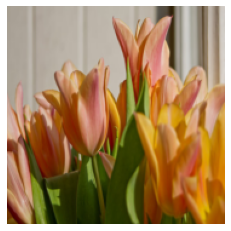

In [89]:
train_image = original[0][0]

plt.imshow(train_image)
plt.axis('off')
plt.grid(b=None)

Visualize several training images:

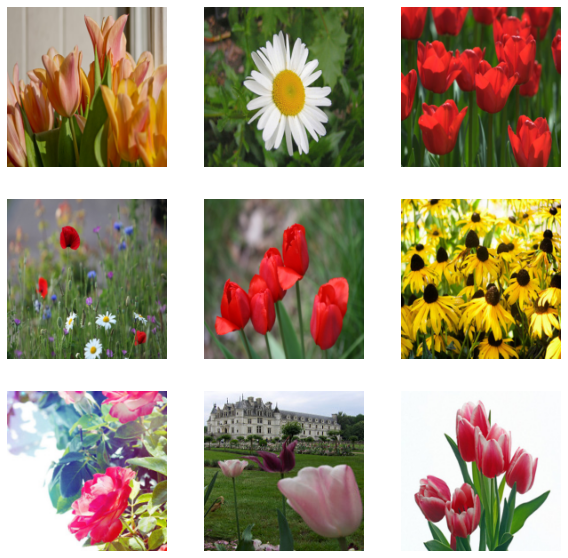

In [90]:
plt.figure(figsize=(10, 10))
for images in original:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

Visualize an augmented image:

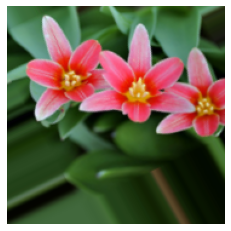

In [91]:
aug_train_image = augmented[0][0]

plt.imshow(aug_train_image)
plt.axis('off')
plt.grid(b=None)

Visualize several augmented images:

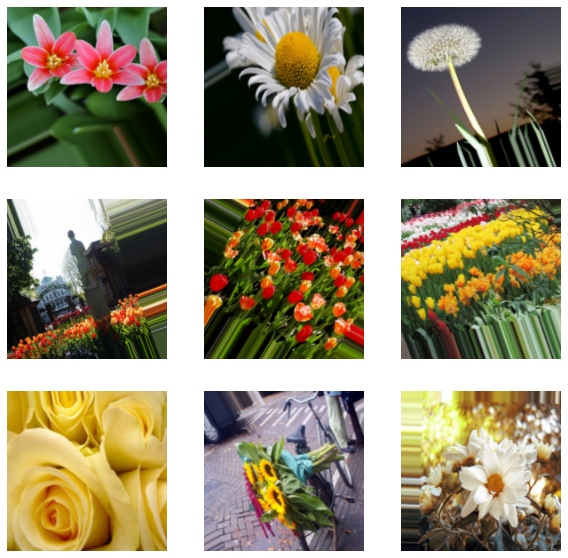

In [92]:
plt.figure(figsize=(10, 10))
for images in augmented:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

The original training images look like normal flower images. However, we see that the augmented images are definitely transformed.